<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_repeat_sampe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion with Repeatable Seeds

This example shows how to use the Stable Diffusion pipeline to tweak generated images using repeatable seeds.

## Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

Install diffusers and required libraries.

In [1]:
#%%capture
#!pip install git+https://github.com/huggingface/diffusers.git
!pip install diffusers==0.12
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 611.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


This demo uses Stable Diffusion. The model weights are released under a permissive license that you have to accept. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), carefully read the license and accept it only if you agree with all its terms. You have to be a registered user in 🤗 Hugging Face Hub to do so.

If you accept the license, you also need to use an access token to access the weights. This is so 🤗 Hugging Face Hub can verify that you indeed accepted the license. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In order to authenticate against the Hub, please run the following cell. We first need to enable externarl widgets because Google Colab recently disabled them; then we trigger an authentication with your user token.

In [2]:
#@markdown ライセンス等の使用条件は[配布サイト](https://huggingface.co/stabilityai/stable-diffusion-2-1)で確認してください。

%%capture
%%shell

MODEL="runwayml/stable-diffusion-v1-5"

mkdir -p $MODEL
cd $MODEL
wget https://huggingface.co/${MODEL}/raw/main/model_index.json

mkdir vae
cd vae
wget https://huggingface.co/${MODEL}/raw/main/vae/config.json
wget https://huggingface.co/${MODEL}/resolve/main/vae/diffusion_pytorch_model.bin

cd ..

mkdir unet
cd unet
wget https://huggingface.co/${MODEL}/raw/main/unet/config.json
wget https://huggingface.co/${MODEL}/resolve/main/unet/diffusion_pytorch_model.bin
cd ..

mkdir tokenizer
cd tokenizer
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/merges.txt
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/special_tokens_map.json
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/tokenizer_config.json
wget https://huggingface.co/${MODEL}/raw/main/tokenizer/vocab.json
cd ..

mkdir text_encoder
cd text_encoder
wget https://huggingface.co/${MODEL}/raw/main/text_encoder/config.json
wget https://huggingface.co/${MODEL}/resolve/main/text_encoder/pytorch_model.bin
cd ..

mkdir scheduler
cd scheduler
wget https://huggingface.co/${MODEL}/raw/main/scheduler/scheduler_config.json
cd ..

mkdir feature_extractor
cd feature_extractor
wget https://huggingface.co/${MODEL}/raw/main/feature_extractor/preprocessor_config.json
cd ..

mkdir safety_checker
cd safety_checker
wget https://huggingface.co/${MODEL}/resolve/main/safety_checker/pytorch_model.bin
wget https://huggingface.co/${MODEL}/raw/main/safety_checker/config.json



cd ..
cd ..

In [3]:
!ls

runwayml  sample_data


## Stable Diffusion Pipeline

We use the half-float precision to save GPU memory. If you want to run inference at full precision, just remove `revision="fp16"` and `torch_dtype=torch.float16` from the cell below.

In [4]:
import torch
from diffusers import StableDiffusionPipeline


device = "cuda"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True, 
    local_files_only=True
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


We'll first generate a few images to see which one we like the most. In order to view them nicely, we'll create a helper function to present results in a grid. This was taken from the 🤗 Hugging Face [Stable Diffusion blog post](https://huggingface.co/blog/stable_diffusion).

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In this example we are going to generate 4 images at once. Feel free to update it depending on how much RAM your GPU has. We also set the desired output resolution to `512 × 512`.

In [6]:
num_images = 4

width = 512
height = 512

### Latents Generation

In order to reuse the seeds we need to generate the latents ourselves. Otherwise, the pipeline will do it internally and we won't have a way to replicate them.

Latents are the initial random Gaussian noise that gets transformed to actual images during the diffusion process.

To generate them, we'll use a different random seed for each latent, and we'll save them so we can reuse them later.

In [7]:
generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (4, 4, 64, 64) in this case
latents.shape

torch.Size([4, 4, 64, 64])

### Generate Images with our Latents

We are now ready to generate the images. We'll send the pipeline the latents we want to use. If we don't, the pipeline will generate a new set for us.

In [8]:
prompt = "Labrador in the style of Vermeer"

with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    ).images

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Cool, let's display them.

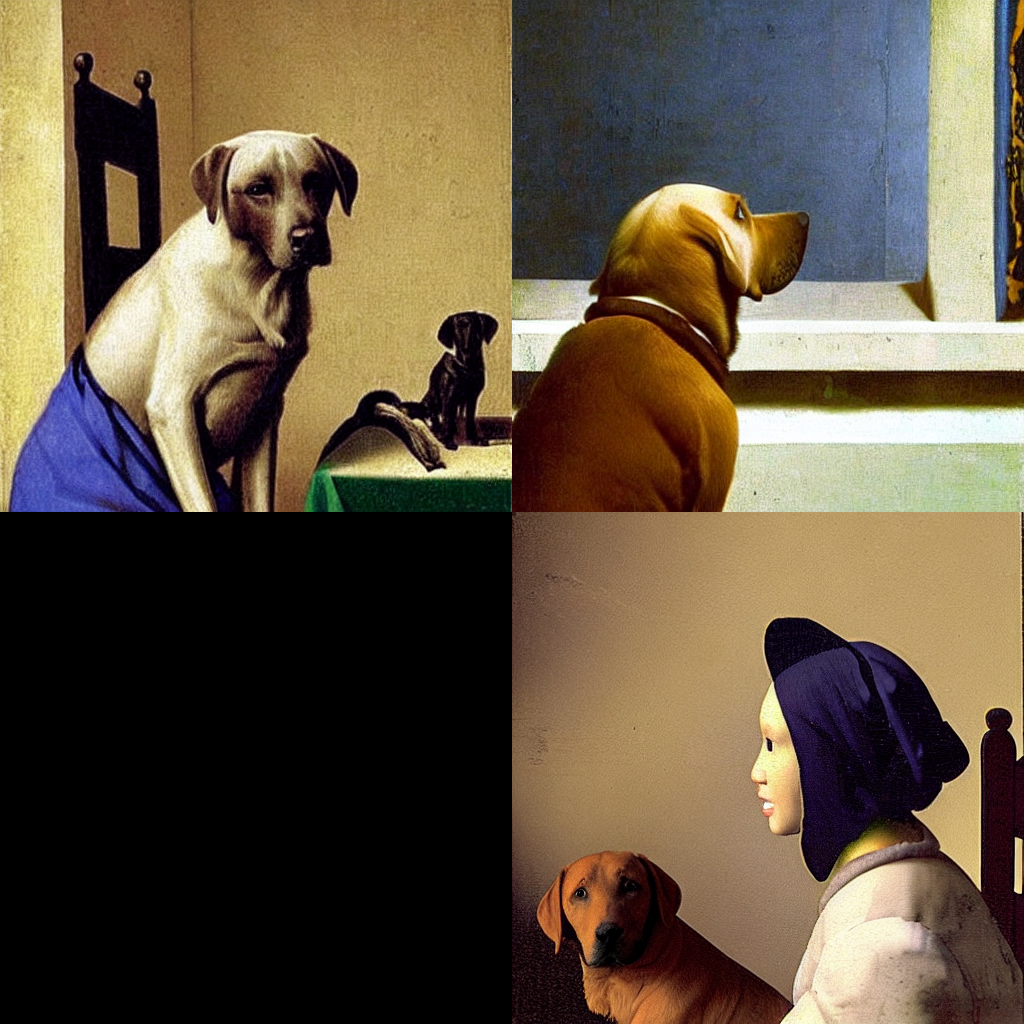

In [9]:
image_grid(images, 2, 2)

I like the second one! If we use the same seed we used before to regenerate those latents, we should get the same result.

In [10]:
seed = seeds[0]   # Second one
seed

7182473204719470

In [11]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

We could just have reused `latents[1]` instead. But just taking note of the seeds will be enough te replicate the generation any time we like.

If we repeat the generation (of a single image) with these latents and the same prompt, we should get the same image as before:

  0%|          | 0/50 [00:00<?, ?it/s]

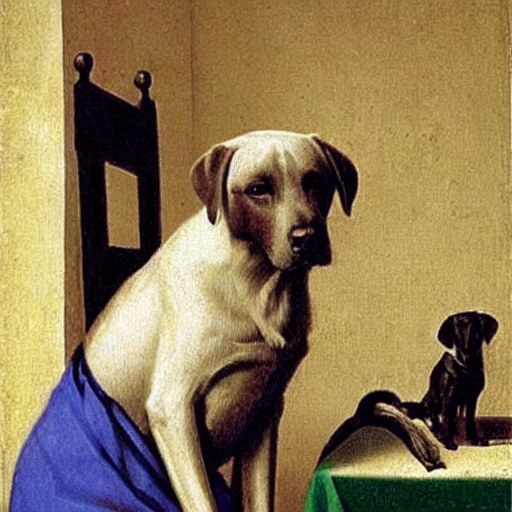

In [12]:
with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

It worked!

We can now try to tweak the prompt _keeping the same latents_. This should create an image with a similar structure but different content or style.

For example:

  0%|          | 0/50 [00:00<?, ?it/s]

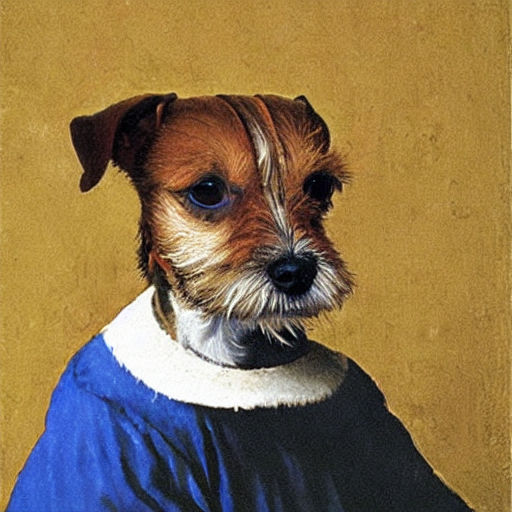

In [13]:
prompt = "Terrier in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

  0%|          | 0/50 [00:00<?, ?it/s]

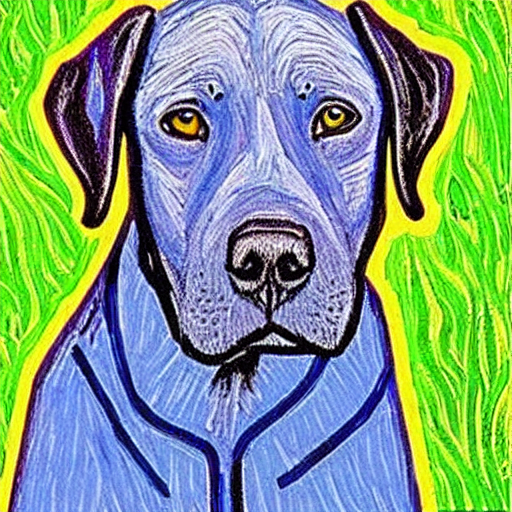

In [14]:
prompt = "Labrador in the style of Van Gogh"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]

  0%|          | 0/50 [00:00<?, ?it/s]

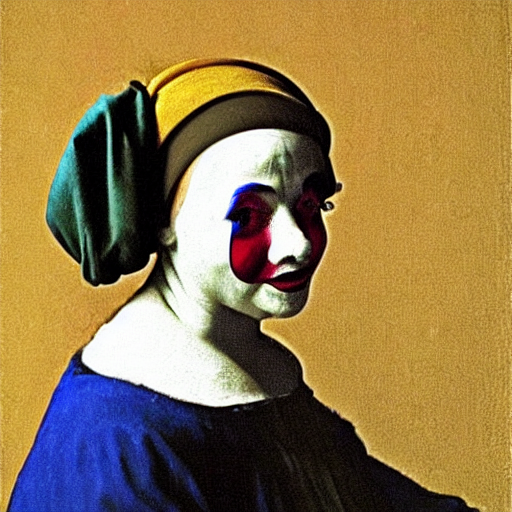

In [15]:
prompt = "Clown in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    ).images
    
image[0]